In [2]:
import gc
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from tqdm import tqdm
from tensorflow.keras import backend as K
warnings.filterwarnings(action='ignore')
K.image_data_format()

'channels_last'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# 기본경로 설정
BASIC_PATH = '/content/drive/Shared drives/SGU/last_version'
DATA_PATH = os.path.join(BASIC_PATH, 'car_model')
SAVE_PATH = os.path.join(BASIC_PATH, 'save')
os.listdir(DATA_PATH)
os.listdir(SAVE_PATH)

['cnn_car_weights.h5', 'cnn_car_model.h5']

In [0]:
# 이미지 폴더 경로
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test')

In [0]:
# CSV 파일 경로
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train_model.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test_model.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class_model.csv'))

In [7]:
df_train.head()

,img_file,class
0,train_001.jpg,1
1,train_002.jpg,1
2,train_003.jpg,1
3,train_004.jpg,1
4,train_005.jpg,1


In [8]:
df_test.head()

,img_file,class
0,test_001.jpg,1
1,test_002.jpg,1
2,test_003.jpg,1
3,test_004.jpg,2
4,test_005.jpg,2


In [9]:
df_class.head()

,class,class_name
0,1,DumpTruck
1,2,Truck
2,3,Bus
3,4,Sedan
4,5,SUV


In [10]:
# Data 누락 체크
if set(list(df_train.img_file)) == set(os.listdir(TRAIN_IMG_PATH)) :
    print("Train file 누락 없음!")
else : 
    print("Train file 누락")

if set(list(df_test.img_file)) == set(os.listdir(TEST_IMG_PATH)) :
    print("Test file 누락 없음!")
else : 
    print("Test file 누락")

Train file 누락 없음!
Test file 누락 없음!


In [11]:
# Data 갯수
print("Number of Train Data : {}".format(df_train.shape[0]))
print("Number of Test Data : {}".format(df_test.shape[0]))

Number of Train Data : 150
Number of Test Data : 18


In [0]:
class_count = df_train['class'].nunique()
print("Train Data의 타겟 종류 갯수 : {}".format(class_count))


Train Data의 타겟 종류 갯수 : 6


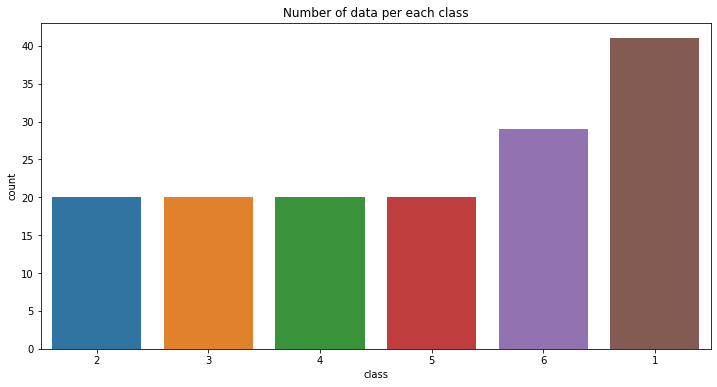

In [12]:
# 분류별 Train 수량
plt.figure(figsize=(12, 6))
sns.countplot(df_train["class"], order=df_train["class"].value_counts(ascending=True).index)
plt.title("Number of data per each class")
plt.show()

In [0]:
# class 최대, 최소 이미지 수량
cntEachClass = df_train["class"].value_counts(ascending=False)
print("가장 많은 차종  : {}, {}개".format(df_class["class_name"][cntEachClass.index[0]], cntEachClass.max()))
print("가장 적은 차종  : {}, {}개".format(df_class["class_name"][cntEachClass.index[-1]], cntEachClass.min()))
print("평균수량  : {}개".format(cntEachClass.mean()))

가장 많은 차종  : Truck, 41개
가장 적은 차종  : Bus, 20개
평균수량  : 25.0개


In [0]:
# class 분포
cntEachClass.describe()

count     6.000000
mean     25.000000
std       8.625543
min      20.000000
25%      20.000000
50%      20.000000
75%      26.750000
max      41.000000
Name: class, dtype: float64

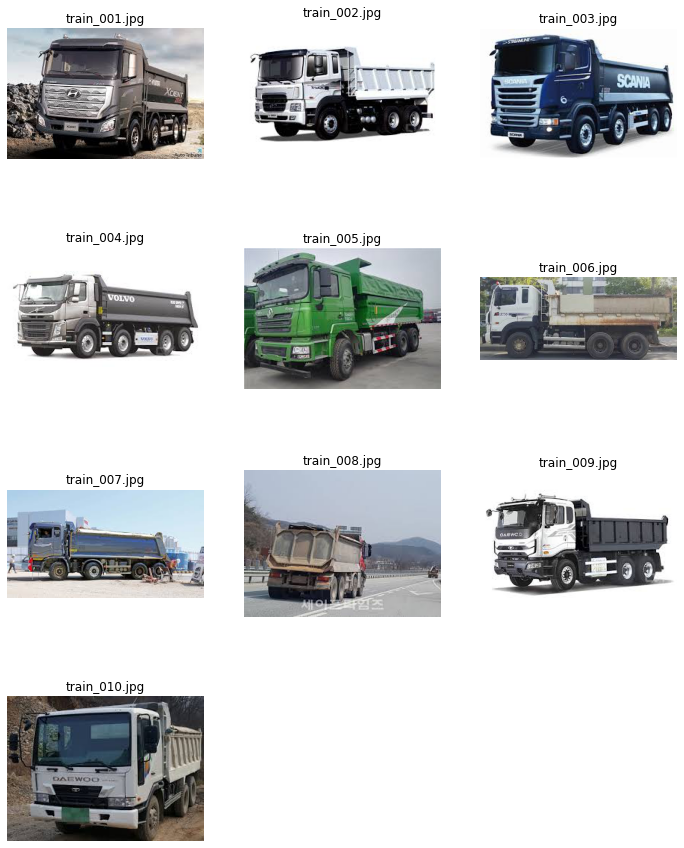

In [0]:
# Train Image 10개
import PIL
from PIL import ImageDraw

tmp_imgs = df_train['img_file'][0:10]
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
    img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
    plt.subplot(5, 3, num + 1)
    plt.title(f_name)
    plt.imshow(img)
    plt.axis('off')

In [0]:
# 8:2 로 training data와 validation data를 나눈다.
from sklearn.model_selection import train_test_split

df_train["class"] = df_train["class"].astype('str')

df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]

its = np.arange(df_train.shape[0])
train_idx, val_idx = train_test_split(its, train_size = 0.8, random_state=42)

X_train = df_train.iloc[train_idx, :]
X_val = df_train.iloc[val_idx, :]

print(X_train.shape)
print(X_val.shape)
print(df_test.shape)

(120, 2)
(30, 2)
(18, 1)


In [0]:
# ImageDataGenerator를 통해 이미지수를 늘려서 Train, Validation, Test Generator를 만든다.
from tensorflow.keras.applications.resnet import ResNet50, ResNet101, ResNet152, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_width, img_height = 224, 224
# Parameter
img_size = (img_width, img_height)
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(df_test)
epochs = 20
batch_size = 32

# Define Generator config
train_datagen = ImageDataGenerator(
    horizontal_flip = True, 
    vertical_flip = False,
    zoom_range=0.10,
    preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Make Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train, 
    directory=TRAIN_IMG_PATH,
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    seed=42
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=X_val, 
    directory=TRAIN_IMG_PATH,
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=TEST_IMG_PATH,
    x_col='img_file',
    y_col=None,
    target_size= img_size,
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle=True
)

Found 120 validated image filenames belonging to 6 classes.
Found 30 validated image filenames belonging to 6 classes.
Found 18 validated image filenames.


In [0]:
# resNet 모델 생성
#wp = '/content/drive/Shared drives/SGU/input/model/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
#resNet_model = ResNet50(include_top=False, weights=wp, input_shape = (img_width, img_height,3))

In [0]:
# 모델 생성
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization

# for layer in resNet_model.layers:
#     layer.trainable = False
#     print(layer,layer.trainable)

model = Sequential()
"""
model.add(resNet_model)
model.add(GlobalAveragePooling2D())
"""

model.add(Conv2D(64, (1, 1), activation = "relu", input_shape = (img_width, img_height, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(16, (1, 1), activation = "relu", input_shape = (img_width, img_height, 3)))
model.add(Conv2D(16, (1, 1), activation = "relu", input_shape = (img_width, img_height, 3)))
model.add(Conv2D(32, (3, 3), activation = "relu", input_shape = (img_width, img_height, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (1, 1), activation = "relu", input_shape = (img_width, img_height, 3)))
model.add(Conv2D(32, (1, 1), activation = "relu", input_shape = (img_width, img_height, 3)))
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = (img_width, img_height, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())

model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(class_count, activation='softmax', kernel_initializer='he_normal'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 16)      1040      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 112, 112, 16)      272       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 110, 110, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 55, 55, 32)       

In [0]:
# 모델 Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# model.fit step값 생서 함수 정의
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0 :
        return (num_samples // batch_size) + 1
    else :
        return num_samples // batch_size

In [0]:
# 모델 훈련
%%time
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1, mode='auto')
#ckpt = ModelCheckpoint(wp, monitor='val_accuracy', verbose = 1, save_best_only = True)

callbackList = []

history = model.fit(
    train_generator,
    steps_per_epoch = get_steps(nb_train_samples, batch_size),
    epochs=epochs,
    verbose=1,
    validation_data = validation_generator,
    validation_steps = get_steps(nb_validation_samples, batch_size),
    callbacks = callbackList
)
gc.collect()

 # 모델 저장
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

model.save(os.path.join(SAVE_PATH, 'cnn_car_model.h5'))
model.save_weights(os.path.join(SAVE_PATH, 'cnn_car_weights.h5'))

Epoch 1/20
4/4 [==============================] - 1s 312ms/step - loss: 1.7142 - accuracy: 0.3167 - val_loss: 1.7506 - val_accuracy: 0.2667
Epoch 2/20
4/4 [==============================] - 1s 309ms/step - loss: 1.6383 - accuracy: 0.3417 - val_loss: 1.7302 - val_accuracy: 0.2333
Epoch 3/20
4/4 [==============================] - 1s 327ms/step - loss: 1.5393 - accuracy: 0.4333 - val_loss: 1.6208 - val_accuracy: 0.3000
Epoch 4/20
4/4 [==============================] - 1s 293ms/step - loss: 1.4836 - accuracy: 0.4333 - val_loss: 1.6581 - val_accuracy: 0.2667
Epoch 5/20
4/4 [==============================] - 1s 296ms/step - loss: 1.3360 - accuracy: 0.4750 - val_loss: 1.7955 - val_accuracy: 0.3000
Epoch 6/20
4/4 [==============================] - 1s 298ms/step - loss: 1.3036 - accuracy: 0.4917 - val_loss: 1.7553 - val_accuracy: 0.3333
Epoch 7/20
4/4 [==============================] - 1s 298ms/step - loss: 1.1965 - accuracy: 0.5417 - val_loss: 1.6405 - val_accuracy: 0.3000
Epoch 8/20
4/4 [====

In [0]:
 # 모델 저장
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

model.save(os.path.join(SAVE_PATH, 'cnn_car_model.h5'))
model.save_weights(os.path.join(SAVE_PATH, 'cnn_car_weights.h5'))

In [0]:
# 훈련 데이터 저장
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


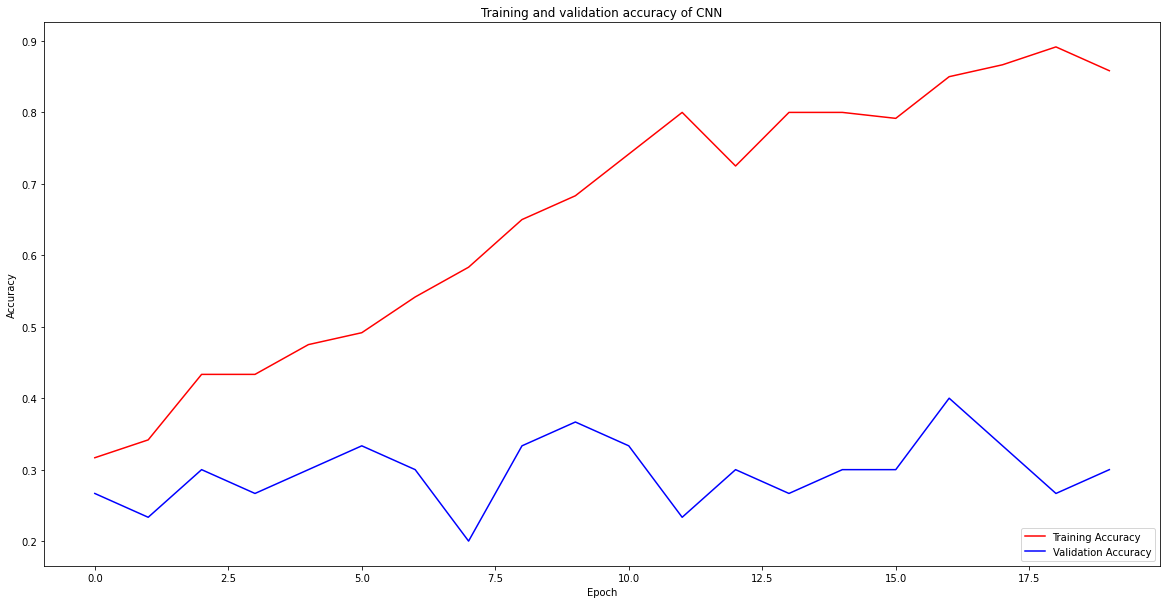

In [0]:
# Accuracy 그래프 저장
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy of CNN')
#plt.ylim([0.7, 1])
plt.legend(loc='lower right')
#plt.show()
fig.savefig(os.path.join(SAVE_PATH, '/Accuracy_curve_resnet50_car_avgpooling.jpg'))


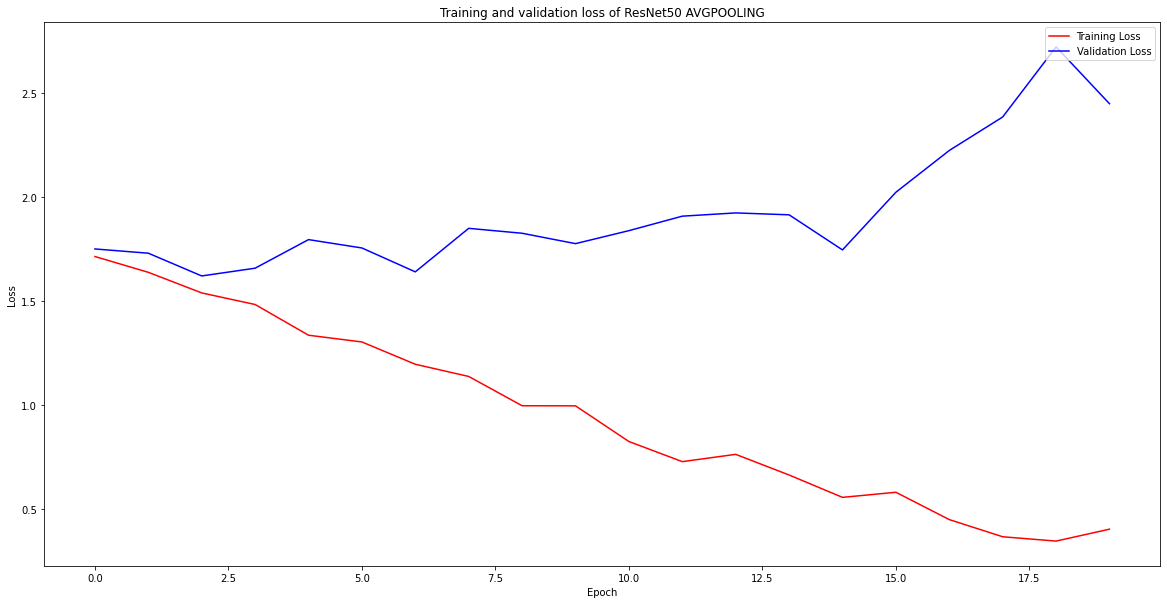

In [0]:
# Loss 그래프 저장
fig2 = plt.figure(figsize=(20,10))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss of ResNet50 AVGPOOLING')
fig2.savefig(os.path.join(SAVE_PATH, '/Loss_curve_resnet50_car_avgpooling.jpg'))


test_002.jpg
1/1 [==============================] - 0s 2ms/step
class별 확률  [9.484e+01 2.900e-01 4.290e+00 1.000e-02 4.000e-02 5.200e-01]


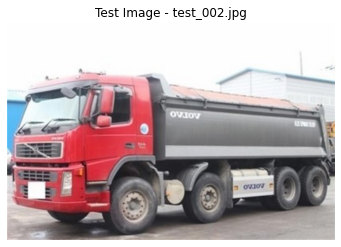

In [19]:
# 테스트 데이터 모델에 삽입하여 분류결과 조회
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_width, img_height = 224, 224

# test csv내의 ROW NUM
test_arr = 1
test_row = df_test.iloc[test_arr]
test_list = df_test['img_file'].tolist()
print(test_list[test_arr])
test_img = plt.imread(os.path.join(TEST_IMG_PATH, test_row["img_file"]))

plt.title("Test Image - {}".format(test_row["img_file"]))
plt.imshow(test_img)
plt.axis('off')

test_img = cv2.resize(test_img,(img_width, img_height))
test_img = np.reshape(test_img,[1,img_width, img_height,3])

model_path = os.path.join(SAVE_PATH, 'cnn_car_model.h5')

#Load the pre-trained models
loaded_model = load_model(model_path)

target_class = loaded_model.predict_classes(test_img)

array = loaded_model.predict(test_img, batch_size=1, verbose=1)
answer = np.argmax(array, axis=1)

print('class별 확률 ', np.round(array[0] * 100, 2))

In [20]:
# 분류명과 Test 이미지와 해당하는 Train 이미지를 보여준다.
import PIL
from PIL import ImageDraw

def test_viewer(test_num, class_num):
    df_class = pd.read_csv(os.path.join(DATA_PATH, 'class_model.csv'))
    class_code = df_class["class"][class_num]
    class_name = df_class["class_name"][class_num]
    print("class code : {}, 분류명 : {}, 확률 : {} %".format(class_code, class_name, np.round(array[0][int(target_class)] * 100, 2)))

    test_dfToList = df_test['img_file'].tolist()
    test_img = PIL.Image.open(os.path.join(TEST_IMG_PATH, test_dfToList[test_num]))
    print("Test images ---------------------------------------------------------------------")
    print("Test Image : {}".format(test_dfToList[test_num]))

    plt.title("Test Image - {}".format(test_dfToList[test_num]))
    plt.imshow(test_img)
    plt.axis('off')

    print("Train images ---------------------------------------------------------------------")
    plt.figure(figsize=(20,40))
    train_class = df_train.loc[df_train["class"] == class_code, ["img_file", "class"]]
    train_list = train_class['img_file'].tolist()
    train_size = len(train_list)
    print("Train count : {} 개".format(train_size))
    for num, img_file in enumerate(train_class["img_file"]):
        img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, img_file))
        plt.subplot(train_size//4 + 1, 4, num + 1)
        plt.title(img_file)
        plt.imshow(img)
        plt.axis('off')

test_viewer(test_arr, target_class[0])

Output hidden; open in https://colab.research.google.com to view.